In [1]:
#baseline
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
def parseData(df):
    """
    预处理数据
    """
    df['rentType'][df['rentType']=='--'] = '未知方式'
    # 转换object类型数据
    columns = ['rentType', 'houseFloor', 'houseToward', 'houseDecoration', 'communityName', 'region', 'plate']
    for col in columns:
        df[col] = df[col].astype('category')
        
    # 将buildYear列转换为整型数据
    tmp = df['buildYear'].copy()
    tmp2 = tmp[tmp!='暂无信息'].astype('int')
    print(len(tmp[tmp!='暂无信息']))
    print(tmp2.median())
#     tmp[tmp=='暂无信息'] = tmp2.mode().iloc[0]
    tmp[tmp=='暂无信息'] = tmp2.median()
    df['buildYear'] = tmp
    df['buildYear'] = df['buildYear'].astype('int')
    
    # 处理pv和uv的空值
    df['pv'].fillna(df['pv'].mean(),inplace=True)
    df['uv'].fillna(df['uv'].mean(),inplace=True)
    df['pv'] = df['pv'].astype('int')
    df['uv'] = df['uv'].astype('int')
    
    # 去掉部分特征
#     df.drop('communityName',axis=1, inplace=True)
    df.drop('city',axis=1,inplace=True)
    
    return df

In [3]:
def washData(df_train, df_test):
    """
    清洗数据
    """
    df_train = df_train[(df_train['area']<=160)&(df_train['area']>17)]
    df_train = df_train[(df_train['tradeMoney']<=16000)&(df_train['tradeMoney']>100)]
    df_train = df_train[(df_train['totalFloor']<=60)&(df_train['totalFloor']>0)]
    df_train = df_train[df_train['saleSecHouseNum']<=15]
    df_train = df_train[df_train['remainNewNum']<=3000]
    
    df_train = df_train[df_train['supplyLandArea']<=400000]
    df_train = df_train[df_train['lookNum']<=18]
    df_train = df_train[df_train['totalFloor']<=60]
    df_train = clean_data(df_train)
    
    df_train.drop('ID', axis=1, inplace=True)
    df_test.drop('ID', axis=1,inplace=True)
    
    return df_train, df_test

In [4]:
def feature(df):
    """
    特征
    """
    # 将houseType转化为‘房间数’，‘厅数’，‘卫生间数’
    def parseRoom(info, index):
        res = int(info[index*2])
        return res
    df.insert(3,'_room',None)
    df.insert(4, '_hall', None)
    df.insert(5, '_toliet', None)
    df['_room'] = df['houseType'].apply(parseRoom, index=0)
    df['_hall'] = df['houseType'].apply(parseRoom, index=1)
    df['_toliet'] = df['houseType'].apply(parseRoom, index=2)
    
    df['交易月份'] = df['tradeTime'].apply(lambda x: int(x.split('/')[1]))
    df['pv/uv'] = df['pv'] / df['uv']
    df['pv*uv'] = df['pv'] * df['uv']
    df['pv+uv'] = df['pv'] + df['uv']
    df['pv-uv'] = df['pv'] - df['uv']
    
#     df['房间总数'] = df['室'] + df['厅'] + df['卫']
    df['_Rooms'] = df['_room'] + df['_hall'] + df['_toliet']
    
    df['stationNum'] = df['subwayStationNum'] + df['busStationNum']
    df['schoolNums'] = df['interSchoolNum'] + df['schoolNum'] + df['privateSchoolNum']
    df['medicalNum'] = df['hospitalNum'] + df['drugStoreNum']
    df['lifeHouseNum'] = df['gymNum'] + df['bankNum'] + df['shopNum'] + df['parkNum'] + df['mallNum'] + df['superMarketNum']
    df = df.drop(['subwayStationNum','busStationNum', 'schoolNum',
                  'interSchoolNum', 'privateSchoolNum',
                  'hospitalNum', 'drugStoreNum',
    'gymNum', 'bankNum', 'shopNum', 'parkNum', 'mallNum', 'superMarketNum'], axis=1)
    
    df['A_area'] = (df['area']*100)**2
    df['A_toliet'] = (df['_toliet']*10)**2
    df['A_room']=(df['_room']*10)**2
    df['A_hall']=(df['_hall']*10)*2
    
    df['_room_hall']=df['_room']+df['_hall']
    df['_room_toliet']=df['_room']+df['_toliet']
    df['_hall_toliet']=df['_hall']+df['_toliet']

    df['_room_num_ratio']=df['_room']/df['_Rooms']
    df['_hall_num_ratio']=df['_hall']/df['_Rooms']
    df['_toliet_num_ratio']=df['_toliet']/df['_Rooms']

    df['mean_area']=df['area']/df['_Rooms']

    df['_room_area']=df['area']* df['_room_num_ratio']
    df['_hall_area']=df['area']* df['_hall_num_ratio']
    df['_toliet_area']=df['area']* df['_toliet_num_ratio']
    
    le = LabelEncoder()
    df['houseFloor'] = le.fit_transform(df['houseFloor'])
#     df['plate'] = le.fit_transform(df['plate'])
    def fun(p):
        if p==0:
            return 0
        elif p==1:
            return 0.3333
        elif p==2:
            return 0.6666
    df['houseFloor']=df['houseFloor'].apply(lambda x:fun(x))
    df['houseFloor_actual']=df['totalFloor']*df['houseFloor']
    
    
    categorical_feats = ['rentType', 'houseToward', 'houseDecoration', 'region', 'plate']
    items = ['area', '_room' ,'_hall','_toliet', 'totalFloor',
       'buildYear', 'saleSecHouseNum','totalTradeMoney', 'totalTradeArea', 'tradeMeanPrice',
       'tradeSecNum', 'totalNewTradeMoney', 'totalNewTradeArea','stationNum','schoolNums','medicalNum',
     'lifeHouseNum','tradeNewMeanPrice', 'tradeNewNum', 'remainNewNum', 'supplyNewNum',
       'supplyLandNum', 'supplyLandArea', 'tradeLandNum', 'tradeLandArea',
       'landTotalPrice', 'landMeanPrice', 'totalWorkers', 'newWorkers',
       'residentPopulation', 'pv', 'uv', 'lookNum']
    
    df.drop('houseType', axis=1, inplace=True)
    df.drop('tradeTime', axis=1, inplace=True)
    
    train_add = df
    for item in items:
        xiaoquname_mean=df.groupby('communityName',as_index=False)[item].agg({item+'mean小区名':'mean',item+'std小区名':'std'})
        train_add = train_add.merge(xiaoquname_mean,on='communityName',how='left')
    
    train_add.drop(['houseFloor','communityName'],axis=1, inplace=True)
    
    
    
    
    return train_add, categorical_feats

In [5]:
# 深度清理
def clean_data(data):
    data.drop(data[(data['region']=='RG00001')&(data['tradeMoney']<1000)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>250)&(data['tradeMoney']<20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00001') & (data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002') & (data['area']<100)&(data['tradeMoney']>60000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']<300)&(data['tradeMoney']>30000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003')&(data['tradeMoney']<500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003')&(data['tradeMoney']<1500)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003')&(data['tradeMoney']<2000)&(data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003')&(data['tradeMoney']>5000)&(data['area']<20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00003') & (data['area']>600)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004')&(data['tradeMoney']<1000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['tradeMoney']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005')&(data['tradeMoney']<2000)&(data['area']>180)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005')&(data['tradeMoney']>50000)&(data['area']<200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006') & (data['area']>200)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007') & (data['area']>100)&(data['tradeMoney']<2500)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>200)&(data['tradeMoney']>25000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010') & (data['area']>400)&(data['tradeMoney']<15000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010')&(data['tradeMoney']<3000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010')&(data['tradeMoney']>7000)&(data['area']<75)].index,inplace=True)
    data.drop(data[(data['region']=='RG00010')&(data['tradeMoney']>12500)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004') & (data['area']>400)&(data['tradeMoney']>20000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<2000)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009') & (data['area']>300)].index,inplace=True)
    data.drop(data[(data['region']=='RG00009')&(data['area']>100)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00011')&(data['tradeMoney']<10000)&(data['area']>390)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012') & (data['area']>120)&(data['tradeMoney']<5000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']<100)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013') & (data['area']>400)&(data['tradeMoney']>50000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00013')&(data['area']>80)&(data['tradeMoney']<2000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014') & (data['area']>300)&(data['tradeMoney']>40000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014')&(data['tradeMoney']<1300)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014')&(data['tradeMoney']<8000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014')&(data['tradeMoney']<1000)&(data['area']>20)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014')&(data['tradeMoney']>25000)&(data['area']>200)].index,inplace=True)
    data.drop(data[(data['region']=='RG00014')&(data['tradeMoney']<20000)&(data['area']>250)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005')&(data['tradeMoney']>30000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005')&(data['tradeMoney']<50000)&(data['area']>600)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005')&(data['tradeMoney']>50000)&(data['area']>350)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006')&(data['tradeMoney']>4000)&(data['area']<100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006')&(data['tradeMoney']<600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00006')&(data['area']>165)].index,inplace=True)
    data.drop(data[(data['region']=='RG00012')&(data['tradeMoney']<800)&(data['area']<30)].index,inplace=True)
    data.drop(data[(data['region']=='RG00007')&(data['tradeMoney']<1100)&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00004')&(data['tradeMoney']>8000)&(data['area']<80)].index,inplace=True)
    data.loc[(data['region']=='RG00002')&(data['area']>50)&(data['rentType']=='合租'),'rentType']='整租'
    data.loc[(data['region']=='RG00014')&(data['rentType']=='合租')&(data['area']>60),'rentType']='整租'
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>15000)&(data['area']<110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']>20000)&(data['area']>110)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['tradeMoney']<1500)&(data['area']<50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00008')&(data['rentType']=='合租')&(data['area']>50)].index,inplace=True)
    data.drop(data[(data['region']=='RG00015') ].index,inplace=True)
    data.drop(data[(data['region']=='RG00014')&(data['tradeMoney']>13000)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005')&(data['tradeMoney']<1200)&(data['area']>80)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005')&(data['tradeMoney']>13000)&(data['area']<90)].index,inplace=True)
    data.drop(data[(data['region']=='RG00005')&(data['tradeMoney']<1600)&(data['area']>100)].index,inplace=True)
    data.drop(data[(data['region']=='RG00002')&(data['tradeMoney']>13000)&(data['area']<100)].index,inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [6]:
def getData(feature):
    """
    获取数据
    """
    train = pd.read_csv('data/train_data.csv')
    test = pd.read_csv('data/test_a.csv')
    
    train = parseData(train)
    test = parseData(test)
    train, test = washData(train, test)
    
    train, col = feature(train)
    test, col = feature(test)
    
    target = train.pop('tradeMoney')
    features = train.columns
    categorical_feats = col
    
    return train, test, target, features, categorical_feats

In [7]:
train, test, target, features, categorical_feats = getData(feature)

38632
2002.0
2341
1999.0


In [8]:
features

Index(['area', 'rentType', '_room', '_hall', '_toliet', 'totalFloor',
       'houseToward', 'houseDecoration', 'region', 'plate',
       ...
       'newWorkersmean小区名', 'newWorkersstd小区名', 'residentPopulationmean小区名',
       'residentPopulationstd小区名', 'pvmean小区名', 'pvstd小区名', 'uvmean小区名',
       'uvstd小区名', 'lookNummean小区名', 'lookNumstd小区名'],
      dtype='object', length=125)

In [9]:
categorical_feats

['rentType', 'houseToward', 'houseDecoration', 'region', 'plate']

In [10]:
params = {
    'num_leaves': 100,
    'min_data_in_leaf': 20,
    'min_child_samples':20,
    'objective': 'regression',
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "feature_fraction": 0.8,
    "bagging_freq": 1,
    "bagging_fraction": 0.85,
    "bagging_seed": 23,
    "metric": 'rmse',
    "lambda_l1": 0.2,
    "nthread": 4,
}

In [11]:
folds = KFold(n_splits=5, shuffle=True, random_state=2333)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()



for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 200)
    
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits
    
print("CV Score: {:<8.5f}".format(r2_score(target, oof_lgb)))

fold 0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 585.857	valid_1's rmse: 710.071
[1000]	training's rmse: 486.353	valid_1's rmse: 688.082
[1500]	training's rmse: 430.456	valid_1's rmse: 684.471
Early stopping, best iteration is:
[1678]	training's rmse: 414.542	valid_1's rmse: 683.967
fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 577.711	valid_1's rmse: 747.252
[1000]	training's rmse: 478.847	valid_1's rmse: 726.969
[1500]	training's rmse: 423.1	valid_1's rmse: 723.014
Early stopping, best iteration is:
[1714]	training's rmse: 404.565	valid_1's rmse: 722.466
fold 2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 585.755	valid_1's rmse: 709.685
[1000]	training's rmse: 486.325	valid_1's rmse: 685.149
[1500]	training's rmse: 429.698	valid_1's rmse: 681.566
Early stopping, best iteration is:
[1564]	training's rmse: 423.717	valid_1's rmse: 681.342
fold 3
Training un

Index(['plate', 'area', '_room_area', 'mean_area', '_hall_area',
       '_toliet_area', 'totalFloormean小区名', 'buildYear', 'houseFloor_actual',
       'areastd小区名', 'areamean小区名', '_roomstd小区名', 'totalFloorstd小区名',
       '_roommean小区名', 'totalFloor', '_hallmean小区名', 'pv/uv', '_hallstd小区名',
       'saleSecHouseNumstd小区名', 'tradeNewMeanPricestd小区名'],
      dtype='object', name='feature')


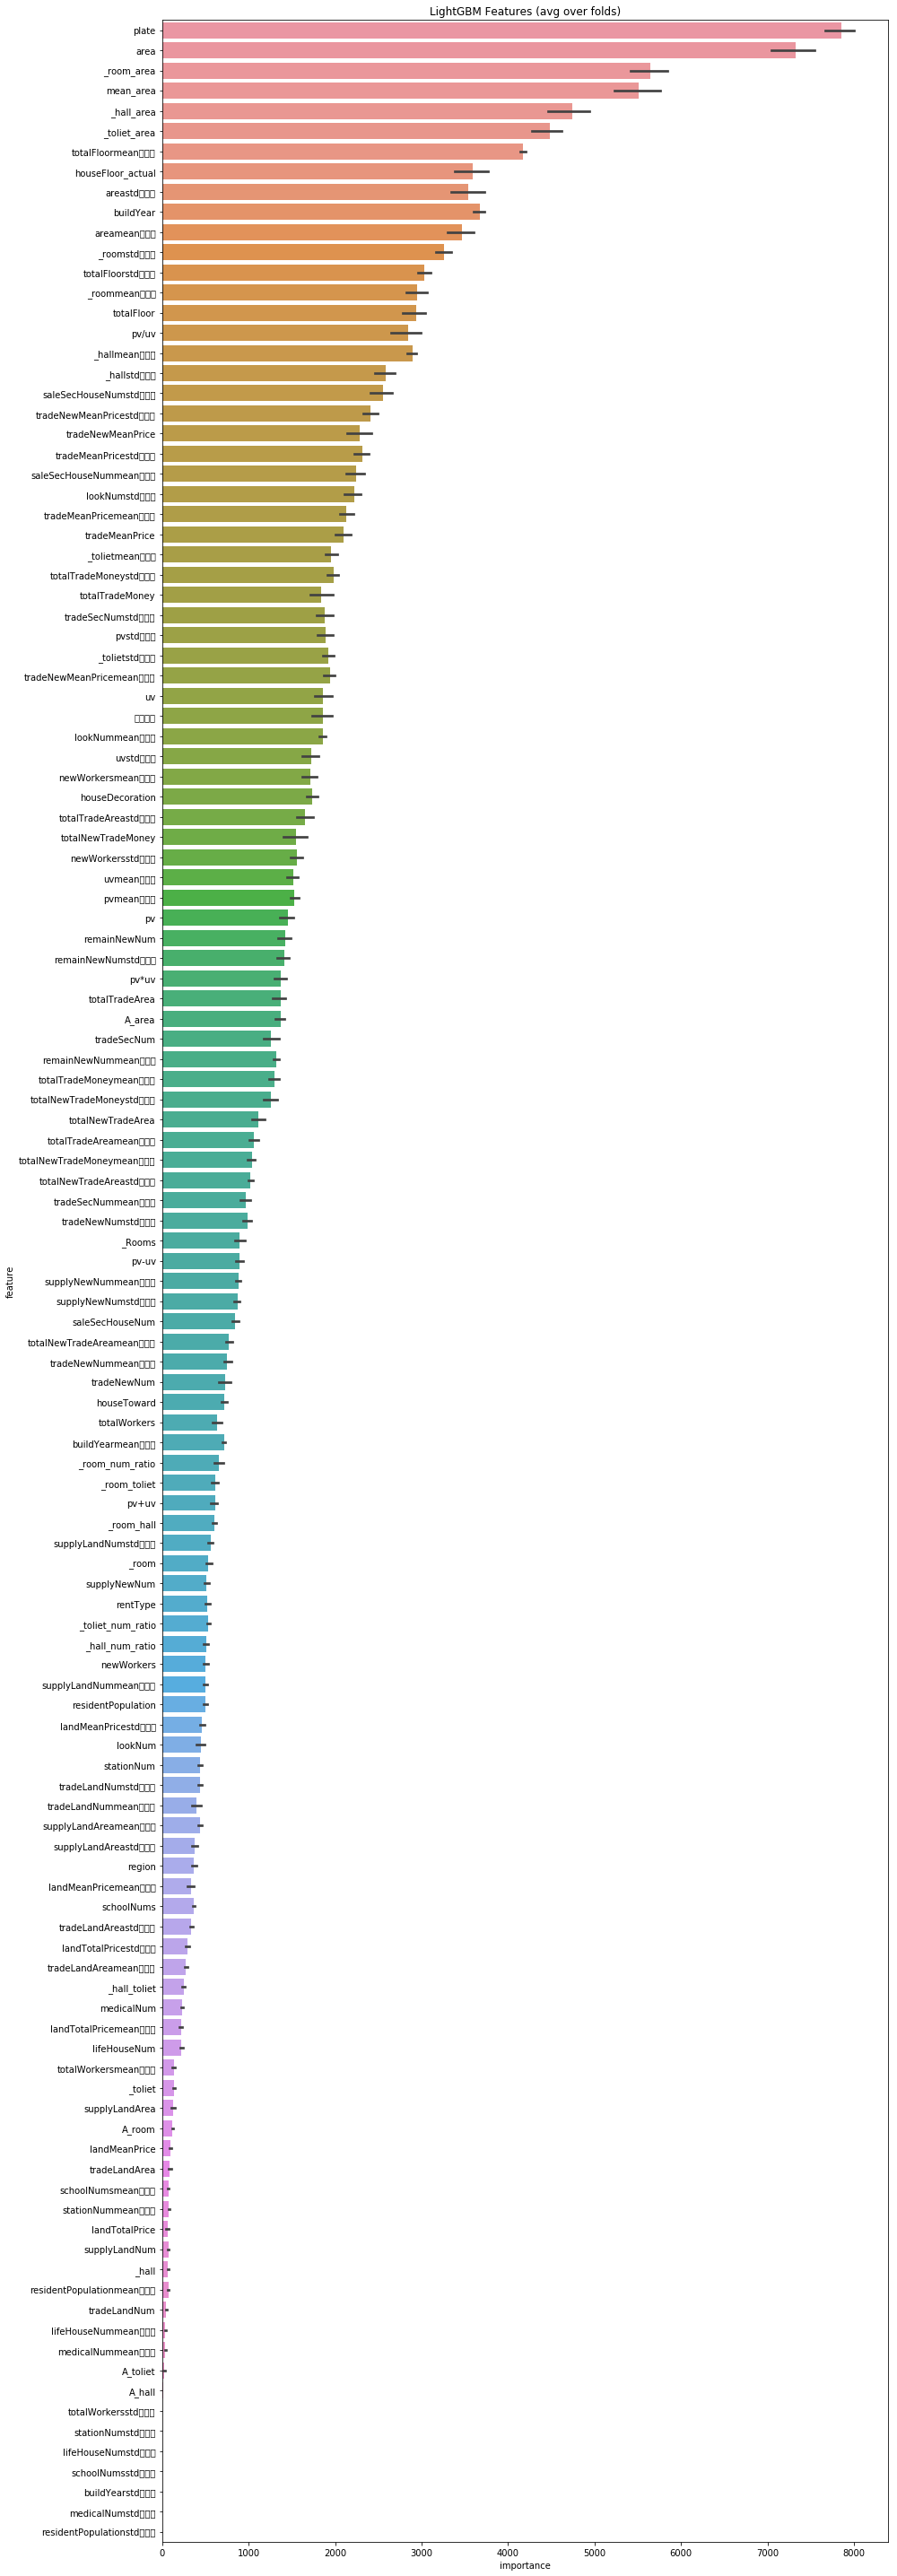

In [17]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
print(cols[:20])
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,40))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [18]:
from sklearn.metrics import r2_score
def online_score(pred):
    print("预测结果最大值：{},预测结果最小值：{}".format(pred.max(),pred.min()))
    # a榜测分
    conmbine1 = pd.read_csv("./best_result/sub_a_913.csv",engine = "python",header=None)
    score1 = r2_score(list(map(lambda x:int(x),pred)), conmbine1.values)
    print("对比913分数:{}".format(score1))

In [19]:
online_score(predictions_lgb)

预测结果最大值：15089.170566938119,预测结果最小值：1237.422837078434
对比913分数:0.9287301923243272


In [21]:
print(len(features))

92


In [22]:
le = LabelEncoder()
for i in categorical_feats:
    train[i] = le.fit_transform(train[i])

In [23]:
#去除含有nan、inf的列
count=0
nan_col = []
for i in features:
    if len(list(set(np.isnan(train[i]).values)))!=1:
#         print(list(set(np.isnan(train[i]).values)))\
        count+=1
        nan_col.append(i)
#         print(i)
print(count)

0


In [24]:
features = list(features)
print(len(features))
features = list(set(features)-set(nan_col))
print(len(features))


92
92


In [ ]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score

lgb = LGBMRegressor(objective='regression', num_leaves=100,boosting='gbdt',
                              learning_rate=0.02, n_estimators=1000, bagging_fraction=0.85,
                              feature_fraction=0.8, lambda_l1=0.2,min_data_in_leaf=20,
                            min_child_samples=20, bagging_seed = 23,bagging_freq = 1,)

 
rfecv = RFECV(estimator=lgb, cv=KFold(n_splits=2, random_state=2019))
rfecv.fit(train[features].values, target.values)
print(rfecv.n_features_)
print(rfecv.ranking_)

In [ ]:
#哎 添加了一些特征，结果变差了。使用refcvs筛选跑了一下午没跑完，不知为何。由于需要回家，
# 就先做到这吧。以后再补上。
